In [1]:
###import packages
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV

import matplotlib.pylab as plt
%matplotlib inline

H:\anaconda\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### load data 
train = pd.read_csv("F:/postguaduate/Machine Learning/Titanic/train.csv")
test = pd.read_csv("F:/postguaduate/Machine Learning/Titanic/test.csv")
target='Survived' # Disbursed的值就是二元分类的输出
IDcol = 'PassengerId'
train.head() #查看数据集内容

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
###数据预处理

###抛弃无关数据
train = train.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)
test = test.drop(['Name','Ticket','Cabin'], axis=1)
train["Embarked"] = train["Embarked"].fillna("S")


###Fare
train['Fare'] = train['Fare'].astype(int)   #float 2 int
test.Fare.fillna(test.Fare.median(), inplace=True)   #插补缺失数据
test['Fare'] = test['Fare'].astype(int)


###Embarked
embark_dummies_train  = pd.get_dummies(train['Embarked'])     # pd.get_dummies()方法对离散数据重新编码，生成0-1矩阵
embark_dummies_test  = pd.get_dummies(test['Embarked'])
train = train.join(embark_dummies_train)   #合并矩阵
test = test.join(embark_dummies_test)
train.drop(['Embarked'], axis=1,inplace=True)   #删除原来的Embark列，inplace=Ture
test.drop(['Embarked'], axis=1,inplace=True)


###Age 主要是对缺失的值进行处理填补
average_age_titanic   = train["Age"].mean()
std_age_titanic       = train["Age"].std()
count_nan_age_titanic = train["Age"].isnull().sum()

average_age_test   = test["Age"].mean()
std_age_test       = test["Age"].std()
count_nan_age_test = test["Age"].isnull().sum()

rand_1 = np.random.randint(average_age_titanic - std_age_titanic, average_age_titanic + std_age_titanic, size = count_nan_age_titanic)
rand_2 = np.random.randint(average_age_test - std_age_test, average_age_test + std_age_test, size = count_nan_age_test)
train["Age"][np.isnan(train["Age"])] = rand_1    
test["Age"][np.isnan(test["Age"])] = rand_2
train['Age'] = train['Age'].astype(int)
test['Age']  = test['Age'].astype(int)


###Sex  考虑到小孩及妇女优先对待，分三类
def get_person(passenger):
    age,sex = passenger
    return "child" if age < 16 else sex

train['Person'] = train[['Age','Sex']].apply(get_person,axis=1)
test['Person']  = test[['Age','Sex']].apply(get_person,axis=1)

train.drop(['Sex'],axis=1,inplace=True)
test.drop(['Sex'],axis=1,inplace=True)

person_dummies_titanic  = pd.get_dummies(train['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']

person_dummies_test  = pd.get_dummies(test['Person'])
person_dummies_test.columns = ['Child','Female','Male']

train = train.join(person_dummies_titanic)
test = test.join(person_dummies_test)
train.drop(['Person'],axis=1,inplace=True)
test.drop(['Person'],axis=1,inplace=True)


###P class
pclass_dummies_titanic  = pd.get_dummies(train['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']

pclass_dummies_test  = pd.get_dummies(test['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']

train.drop(['Pclass'],axis=1,inplace=True)
test.drop(['Pclass'],axis=1,inplace=True)

train = train.join(pclass_dummies_titanic)
test= test.join(pclass_dummies_test)

train.head()

H:\anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
H:\anaconda\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Survived,Age,SibSp,Parch,Fare,C,Q,S,Child,Female,Male,Class_1,Class_2,Class_3
0,0,22,1,0,7,0,0,1,0,0,1,0,0,1
1,1,38,1,0,71,1,0,0,0,1,0,1,0,0
2,1,26,0,0,7,0,0,1,0,1,0,0,0,1
3,1,35,1,0,53,0,0,1,0,1,0,1,0,0
4,0,35,0,0,8,0,0,1,0,0,1,0,0,1


In [4]:
###编写一个函数来调用模型
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Survived'])

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtrain['Survived'], cv=cv_folds, scoring='roc_auc')

    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Survived'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Survived'], dtrain_predprob))

    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))

    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8967
AUC Score (Train): 0.940905
CV Score : Mean - 0.86991 | Std - 0.03776578 | Min - 0.809025 | Max - 0.9197922


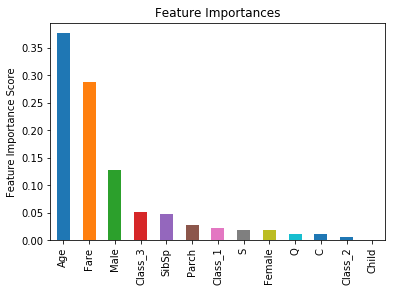

In [5]:
###首先创建一个baseline model，不使用任何参数优化
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0,train,predictors)

In [6]:
####开始调参
predictors = [x for x in train.columns if x not in [target, IDcol]]
#首先从长和迭代次数开始进行网格搜索
param_test1 = {'n_estimators':range(20,101,10),'learning_rate':[0.1,0.12,0.14,0.16]}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(min_samples_split=10,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

H:\anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85661, std: 0.02378, params: {'learning_rate': 0.1, 'n_estimators': 20},
  mean: 0.86181, std: 0.02230, params: {'learning_rate': 0.1, 'n_estimators': 30},
  mean: 0.86384, std: 0.02458, params: {'learning_rate': 0.1, 'n_estimators': 40},
  mean: 0.86541, std: 0.02591, params: {'learning_rate': 0.1, 'n_estimators': 50},
  mean: 0.86761, std: 0.02563, params: {'learning_rate': 0.1, 'n_estimators': 60},
  mean: 0.86848, std: 0.02701, params: {'learning_rate': 0.1, 'n_estimators': 70},
  mean: 0.86999, std: 0.02591, params: {'learning_rate': 0.1, 'n_estimators': 80},
  mean: 0.86960, std: 0.02838, params: {'learning_rate': 0.1, 'n_estimators': 90},
  mean: 0.87037, std: 0.02896, params: {'learning_rate': 0.1, 'n_estimators': 100},
  mean: 0.85747, std: 0.02243, params: {'learning_rate': 0.12, 'n_estimators': 20},
  mean: 0.86251, std: 0.02124, params: {'learning_rate': 0.12, 'n_estimators': 30},
  mean: 0.86495, std: 0.02371, params: {'learning_rate': 0.12, 'n_estimators': 40},


In [7]:
#上述步骤确定了最佳步长0.14，最佳迭代次数90.
#接下来对决策树进行调参。ma_depth和min_sampls_split
param_test2 = {'max_depth':range(2,16,2), 'min_samples_split':range(5,31,5)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.14, n_estimators=90, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

H:\anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87179, std: 0.02815, params: {'max_depth': 2, 'min_samples_split': 5},
  mean: 0.87021, std: 0.02847, params: {'max_depth': 2, 'min_samples_split': 10},
  mean: 0.87003, std: 0.02856, params: {'max_depth': 2, 'min_samples_split': 15},
  mean: 0.87050, std: 0.02883, params: {'max_depth': 2, 'min_samples_split': 20},
  mean: 0.87060, std: 0.02870, params: {'max_depth': 2, 'min_samples_split': 25},
  mean: 0.86982, std: 0.02872, params: {'max_depth': 2, 'min_samples_split': 30},
  mean: 0.86536, std: 0.03173, params: {'max_depth': 4, 'min_samples_split': 5},
  mean: 0.86874, std: 0.03219, params: {'max_depth': 4, 'min_samples_split': 10},
  mean: 0.86370, std: 0.03337, params: {'max_depth': 4, 'min_samples_split': 15},
  mean: 0.86496, std: 0.03275, params: {'max_depth': 4, 'min_samples_split': 20},
  mean: 0.86809, std: 0.03627, params: {'max_depth': 4, 'min_samples_split': 25},
  mean: 0.86639, std: 0.03208, params: {'max_depth': 4, 'min_samples_split': 30},
  mean: 0.86279, s

In [8]:
#上述步骤确定了最佳'max_depth': 4, 'min_samples_split': 25，深度小可能是由于数据量较小所致
#接下来选择叶结点最小样本数
param_test3 = { 'min_samples_leaf':range(50,101,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.14, n_estimators=90,max_depth=4,min_samples_split=25,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

H:\anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86844, std: 0.03208, params: {'min_samples_leaf': 50},
  mean: 0.86866, std: 0.02804, params: {'min_samples_leaf': 60},
  mean: 0.86874, std: 0.02683, params: {'min_samples_leaf': 70},
  mean: 0.86575, std: 0.02786, params: {'min_samples_leaf': 80},
  mean: 0.86279, std: 0.02307, params: {'min_samples_leaf': 90},
  mean: 0.85936, std: 0.02117, params: {'min_samples_leaf': 100}],
 {'min_samples_leaf': 70},
 0.8687437758945185)

In [9]:
#上述步骤确定'min_samples_leaf': 70
#接下来选择最大特征数
param_test4 = {'max_features':range(1,14,1)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.14, n_estimators=90,max_depth=4,min_samples_leaf=70, min_samples_split=25,  subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

H:\anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85887, std: 0.01715, params: {'max_features': 1},
  mean: 0.86782, std: 0.02271, params: {'max_features': 2},
  mean: 0.86874, std: 0.02683, params: {'max_features': 3},
  mean: 0.87048, std: 0.02448, params: {'max_features': 4},
  mean: 0.87080, std: 0.02823, params: {'max_features': 5},
  mean: 0.87112, std: 0.02769, params: {'max_features': 6},
  mean: 0.86968, std: 0.02929, params: {'max_features': 7},
  mean: 0.86987, std: 0.02883, params: {'max_features': 8},
  mean: 0.86914, std: 0.02992, params: {'max_features': 9},
  mean: 0.87011, std: 0.03205, params: {'max_features': 10},
  mean: 0.86792, std: 0.03157, params: {'max_features': 11},
  mean: 0.86881, std: 0.03282, params: {'max_features': 12},
  mean: 0.87013, std: 0.03174, params: {'max_features': 13}],
 {'max_features': 6},
 0.8711241269543317)

In [10]:
#上述步骤中最大特征数为3 感觉不符合实际，所以还是选择默认情况
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.14, n_estimators=90,max_depth=4,min_samples_split=25, min_samples_leaf=70, random_state=10,max_features="sqrt"),
param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

H:\anaconda\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86334, std: 0.02122, params: {'subsample': 0.6},
  mean: 0.86717, std: 0.02505, params: {'subsample': 0.7},
  mean: 0.86841, std: 0.02286, params: {'subsample': 0.75},
  mean: 0.86874, std: 0.02683, params: {'subsample': 0.8},
  mean: 0.86924, std: 0.02561, params: {'subsample': 0.85},
  mean: 0.87143, std: 0.02639, params: {'subsample': 0.9}],
 {'subsample': 0.9},
 0.8714302128727619)

In [11]:
Y_pred = gsearch5.predict(test.drop('PassengerId',axis=1))


Model Report
Accuracy : 0.8496
AUC Score (Train): 0.902476
CV Score : Mean - 0.8679868 | Std - 0.02722333 | Min - 0.8225955 | Max - 0.9077847


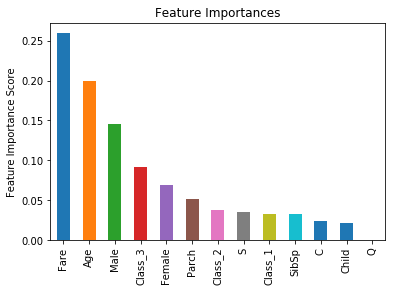

In [12]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.07, n_estimators=180,max_depth=4, min_samples_split=25,min_samples_leaf=70, subsample=0.8, random_state=10, max_features="sqrt")
modelfit(gbm_tuned_1, train, predictors)


Model Report
Accuracy : 0.8552
AUC Score (Train): 0.906582
CV Score : Mean - 0.8730606 | Std - 0.02956442 | Min - 0.827141 | Max - 0.9181732


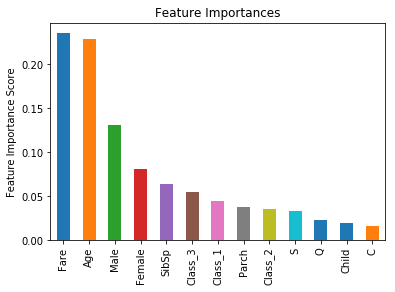

In [13]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.07, n_estimators=140,max_depth=3, min_samples_split=10,min_samples_leaf=30, subsample=0.85, random_state=10, max_features="sqrt")
modelfit(gbm_tuned_1, train, predictors)

In [14]:
my_submission =pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(),'Survived': Y_pred.astype(np.int32)})
my_submission.to_csv("F:/postguaduate/Machine Learning/Titanic/my_submission2.csv",index=False)

In [15]:
#这里看一下不做优化的预测情况，以作对比
Y_pred = gbm0.predict(test.drop('PassengerId',axis=1))

my_submission =pd.DataFrame({'PassengerId': test['PassengerId'].as_matrix(),'Survived': Y_pred.astype(np.int32)})
my_submission.to_csv("F:/postguaduate/Machine Learning/Titanic/my_submission2.csv",index=False)